In [2]:
import numpy as np
import dedalus.public as d3
import dedalus.core as d4
import logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
import pathlib
import subprocess
import h5py
import glob
import re

In [5]:
RA=[4, 5, 6]
QDs=[0, 28e-4, 14e-3, 7e-2]
Names=['0','28e-4','14e-3','7e-2']
Lx, Lz = 16, 1
Nx, Nz = 1024, 64
Md = 3
Vaisala= 4
Prandtl = 0.7
dealias = 3/2
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

In [ ]:
logger = logging.getLogger(__name__)

for i in range(len(QDs)):
    for ra in RA:
    # Parameters
        QD=QDs[i]
        QM=QD/2
        Rayleigh=4*10**ra
        kappa = (Lz**3*Md)/(Rayleigh * Prandtl)**(1/2)
        nu = (Lz**3*Md)/(Rayleigh / Prandtl)**(1/2)
        stop_sim_time = 1.2/nu
        
        # Bases
        coords = d3.CartesianCoordinates('x', 'z')
        dist = d3.Distributor(coords, dtype=dtype)
        xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
        zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

        # Fields
        p = dist.Field(name='p', bases=(xbasis,zbasis))
        d = dist.Field(name='d', bases=(xbasis,zbasis))
        m = dist.Field(name='m', bases=(xbasis,zbasis))
        u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
        tau_p = dist.Field(name='tau_p')
        tau_d1 = dist.Field(name='tau_d1', bases=xbasis)
        tau_d2 = dist.Field(name='tau_d2', bases=xbasis)
        tau_m1 = dist.Field(name='tau_m1', bases=xbasis)
        tau_m2 = dist.Field(name='tau_m2', bases=xbasis)
        tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
        tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

        # Substitutions
        x, z = dist.local_grids(xbasis, zbasis)
        ex, ez = coords.unit_vector_fields(dist)
        lift_basis = zbasis.derivative_basis(1)
        lift = lambda A: d3.Lift(A, lift_basis, -1)
        grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
        grad_d = d3.grad(d) + ez*lift(tau_d1) # First-order reduction
        grad_m = d3.grad(m) + ez*lift(tau_m1) # First-order reduction
        ncc = dist.Field(name='ncc', bases=zbasis)
        ncc['g'] = z
        ncc.change_scales(3/2)
        B = (m+d-Vaisala*ncc+np.absolute(m-d+Vaisala*ncc))/2
        u_x = u @ ex
        u_z = u @ ez
        dz = lambda A: d3.Differentiate(A, coords['z'])
        integ = lambda A: d3.Integrate(A, coords)
        integ1= lambda A: d3.Integrate(A, coords)

        # Problem
        # First-order form: "div(f)" becomes "trace(grad_f)"
        # First-order form: "lap(f)" becomes "div(grad_f)"
        problem = d3.IVP([p, d, m, u, tau_p, tau_d1, tau_d2, tau_m1, tau_m2, tau_u1, tau_u2], namespace=locals())
        problem.add_equation("trace(grad_u) + tau_p = 0")
        problem.add_equation("dt(d) - kappa*div(grad_d) + lift(tau_d2) = - u@grad(d)")
        problem.add_equation("dt(m) - kappa*div(grad_m) + lift(tau_m2) = - u@grad(m)")
        problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) + lift(tau_u2) = - u@grad(u)+ B*ez ")
        problem.add_equation("d(z=0) = 0")
        problem.add_equation("m(z=0) = 0")
        problem.add_equation("d(z=Lz) = 1")
        problem.add_equation("m(z=Lz) = -3")
        problem.add_equation("u_z(z=0) = 0")
        problem.add_equation("u_z(z=Lz) = 0")
        problem.add_equation("dz(u_x)(z=0) = 0")
        problem.add_equation("dz(u_x)(z=Lz)= 0")
        problem.add_equation("integ(p) = 0") # Pressure gauge

        # Solver
        solver = problem.build_solver(timestepper)
        solver.stop_sim_time = stop_sim_time

        # Initial conditions
        d.fill_random('g', seed=23, distribution='normal', scale=1e-3) # Random noise
        d['g'] *= z * (Lz - z) # Damp noise at walls
        d['g'] += z # Add linear background
        m.fill_random('g', seed=41, distribution='normal', scale=1e-3) # Random noise
        m['g'] *= z * (Lz - z) # Damp noise at walls
        m['g'] += -3 * z # Add linear background

        # Analysis
        snapshot_name = f'snapshots {Names[i]}, 4e{ra}'
        snapshots = solver.evaluator.add_file_handler(snapshot_name, sim_dt=0.25, max_writes=50)
        snapshots.add_task(d, name='dry buoyancy')
        snapshots.add_task(m, name='moist buoyancy')
        snapshots.add_task(B, name='buoyancy')
        snapshots.add_task(B-d+Vaisala*ncc, name='additional buoyancy')
        snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')
        snapshots.add_task(0.5*d3.dot(u,u), name='KE')
        snapshots.add_task(integ1(0.5*d3.dot(u,u)), name='total KE')

        # CFL
        CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
                     max_change=1.5, min_change=0.5, max_dt=max_timestep)
        CFL.add_velocity(u)

        # Flow properties
        flow = d3.GlobalFlowProperty(solver, cadence=10)
        flow.add_property(np.sqrt(u@u)/nu, name='Re')

        # Main loop
        startup_iter = 10
        try:
            logger.info('Starting main loop')
            while solver.proceed:
                timestep = CFL.compute_timestep()
                solver.step(timestep)
                if (solver.iteration-1) % 10 == 0:
                    max_Re = flow.max('Re')
                    #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
        except:
            logger.error('Exception raised, triggering end of main loop.')
            raise
        finally:
            solver.log_stats()


In [ ]:
# Parameters
Lx, Lz = 16, 1
Nx, Nz = 512, 32
Md = 3
Rayleigh = 1e6
Vaisala= 4
Prandtl = 0.7
dealias = 3/2
stop_sim_time = 200
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
d = dist.Field(name='d', bases=(xbasis,zbasis))
m = dist.Field(name='m', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_d1 = dist.Field(name='tau_d1', bases=xbasis)
tau_d2 = dist.Field(name='tau_d2', bases=xbasis)
tau_m1 = dist.Field(name='tau_m1', bases=xbasis)
tau_m2 = dist.Field(name='tau_m2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
kappa = (Lz**3*Md)/(Rayleigh * Prandtl)**(1/2)
nu = (Lz**3*Md)/(Rayleigh / Prandtl)**(1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_d = d3.grad(d) + ez*lift(tau_d1) # First-order reduction
grad_m = d3.grad(m) + ez*lift(tau_m1) # First-order reduction
ncc = dist.Field(name='ncc', bases=zbasis)
ncc['g'] = z
ncc.change_scales(3/2)
B = (m+d-Vaisala*ncc+np.absolute(m-d+Vaisala*ncc))/2
u_x = u @ ex
u_z = u @ ez
dz = lambda A: d3.Differentiate(A, coords['z'])
integ = lambda A: d3.Integrate(A, coords)
integ1= lambda A: d3.Integrate(A, coords)

# Initial conditions
d.fill_random('g', seed=22, distribution='normal', scale=1e-3) # Random noise
d['g'] *= z * (Lz - z) # Damp noise at walls
d['g'] += z # Add linear background
m.fill_random('g', seed=39, distribution='normal', scale=1e-3) # Random noise
m['g'] *= z * (Lz - z) # Damp noise at walls
m['g'] += -3 * z # Add linear background


In [ ]:
sum(sum((m['g']-d['g']+Vaisala*z)))

In [ ]:
print(subprocess.check_output("find snapshots | sort", shell=True).decode())

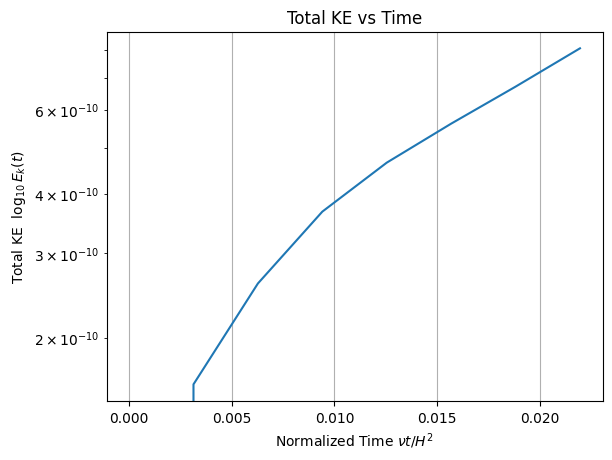

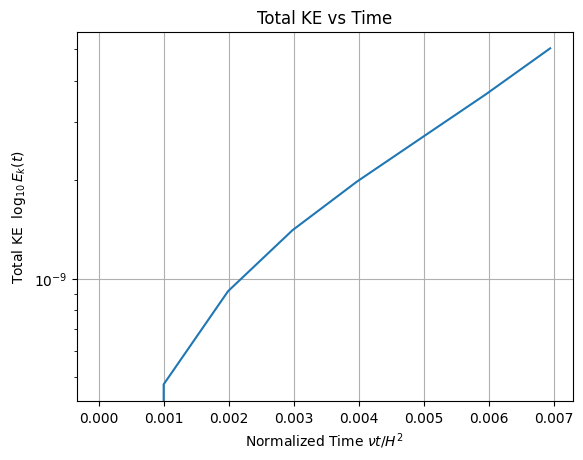

IndexError: list index out of range

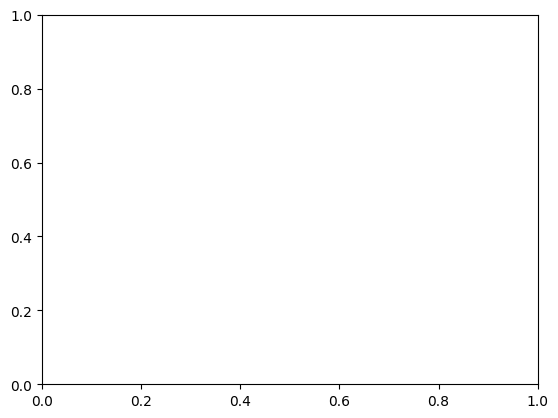

In [7]:
for i in range(len(QDs)):
    QD=QDs[i]
    for ra in RA:
        nu = (Lz**3*Md)/(4*10**ra / Prandtl)**(1/2)
        files = sorted(glob.glob(f'snapshots {Names[i]}, 4e{ra}/*.h5'),key=lambda f: int(re.sub('\D', '', f)))
        fig, ax = plt.subplots()

        with h5py.File(files[0], mode='r') as file:
            KEs = file['tasks']['total KE'][:,:,:]

        for i in range(1,len(files)):
            with h5py.File(files[i], mode='r') as file:
                KE = file['tasks']['total KE'][:,:,:]
                KEs=np.append(KEs,KE,axis=0)
       
        ax.plot(np.arange(len(KEs[:,0,0]))/4*nu, KEs[:,0,0])

        ax.set_title('Total KE vs Time')
        ax.grid(True)
        ax.set_xlabel(r"Normalized Time $\nu t/H^2$")
        ax.set_ylabel(r"Total KE  $\log_{10}E_k(t)$")
        ax.set_yscale('log')
        plt.savefig(f'Total KE vs Time {Names[i]}, 4e{ra}')
        plt.show()
        

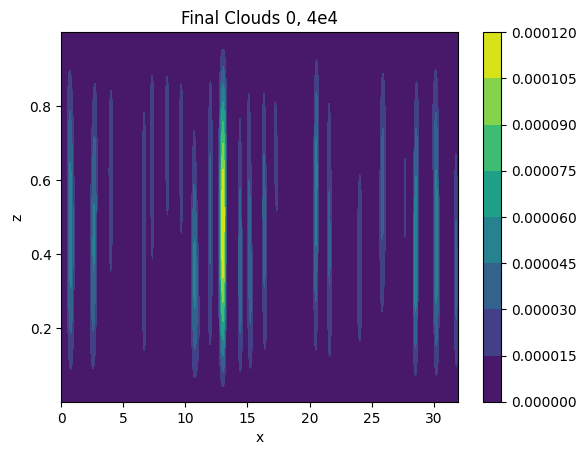

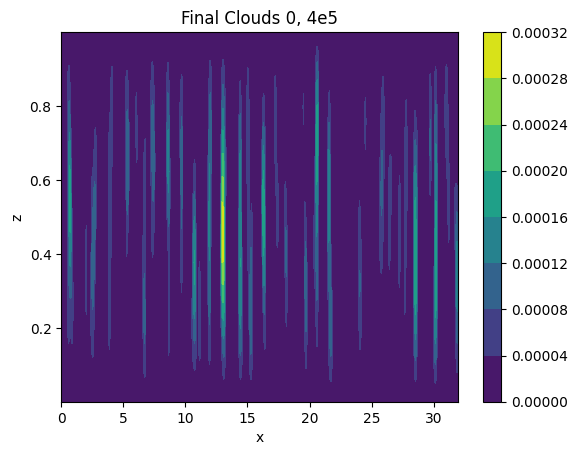

IndexError: list index out of range

In [8]:
for i in range(len(QDs)):
    QD=QDs[i]
    for ra in RA:
        files = sorted(glob.glob(f'snapshots {Names[i]}, 4e{ra}/*.h5'),key=lambda f: int(re.sub('\D', '', f)))
        with h5py.File(files[-1], mode='r') as file:
            moist_buoyancy1 = file['tasks']['moist buoyancy']
            xgrid=moist_buoyancy1.dims[1][0][:]
            zgrid=moist_buoyancy1.dims[2][0][:]
            moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
            dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :]
            buoyancy=np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*zgrid)
            saturation=moist_buoyancy-dry_buoyancy+Vaisala*zgrid
            extra_buoyancy=buoyancy-(dry_buoyancy-Vaisala*zgrid)


            # Plotting extra buoyancy
            plt.figure()
            plt.contourf(xgrid, zgrid, extra_buoyancy[-1,:,:].T)
            plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('z')
            plt.title(f'Final Clouds {Names[i]}, 4e{ra}')
            plt.savefig(f'Final Clouds {Names[i]}, 4e{ra}')
            plt.show()


finished processing
2023-07-05 10:59:08,851 matplotlib.animation 0/1 WARNING :: MovieWriter imagemagick unavailable; using Pillow instead.
2023-07-05 10:59:08,853 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


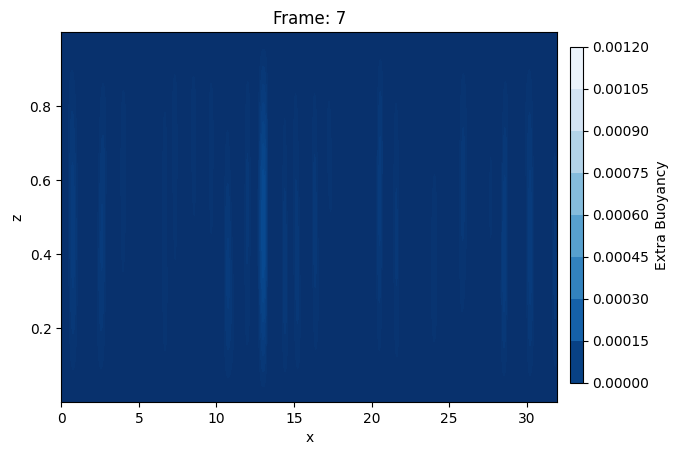

finished processing
2023-07-05 10:59:10,283 matplotlib.animation 0/1 WARNING :: MovieWriter imagemagick unavailable; using Pillow instead.
2023-07-05 10:59:10,287 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


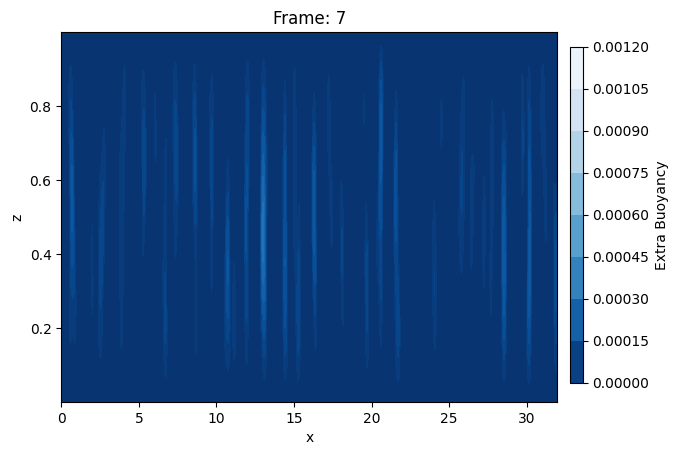

IndexError: list index out of range

In [9]:
for i in range(len(QDs)):
    QD=QDs[i]
    for ra in RA:
        files = sorted(glob.glob(f'snapshots {Names[i]}, 4e{ra}/*.h5'),key=lambda f: int(re.sub('\D', '', f)))
        with h5py.File(files[0], mode='r') as file:
            extra_buoyancy = file['tasks']['additional buoyancy'][:, :, :]
            xgrid=file['tasks']['additional buoyancy'].dims[1][0][:]
            zgrid=file['tasks']['additional buoyancy'].dims[2][0][:]
            clouds = np.where(extra_buoyancy < 0, 0, extra_buoyancy)
        for i in range(1,len(files)):
            with h5py.File(files[i], mode='r') as file:
                extra_buoyancy = file['tasks']['additional buoyancy'][:, :, :] 
                clouds=np.append(clouds,extra_buoyancy,axis=0)

        clouds = np.where(clouds < 0, 0, clouds)     
        global_min=np.min(clouds) 
        global_max=np.max(clouds)
        conditon = (clouds == global_max)
        max_pos = np.where(conditon)
        print("finished processing")
        fig, ax = plt.subplots()
        cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Define colorbar axes position
        img = ax.contourf(xgrid, zgrid, clouds[int(max_pos[0]), :, :].T, vmin=global_min, vmax=global_max,cmap='Blues_r' )
        cb = fig.colorbar(img, cax=cax)
        cb.set_label('Extra Buoyancy')
        def animate(frame):
            ax.clear()
            img = ax.contourf(xgrid, zgrid, clouds[frame, :, : ].T,vmin=global_min, vmax=global_max,cmap='Blues_r')
            ax.set_title('Frame: {}'.format(frame))
            ax.set_xlabel('x')  # Add x-axis label
            ax.set_ylabel('z')  # Add y-axis label

        # Call animate method
        animation = FuncAnimation(fig, animate, frames=len(clouds), interval=100, blit=False)
        animation.save(f'clouds {Names[i]}, 4e{ra}.gif', writer='imagemagick')
        # Display the plot
        plt.show()